In [5]:
# ============================================================================
# 0. LIBRERÍAS Y CONFIGURACIÓN DEL ENTORNO
# ============================================================================
# !pip install pandas numpy scikit-learn scipy matplotlib seaborn statsmodels

import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Librerías ML
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Validaciones estadísticas (CORREGIDO AQUÍ)
from scipy import stats
from scipy.stats import shapiro, jarque_bera # Breusch-Pagan NO va aquí
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan # Esta es la ubicación correcta

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("PROYECTO PRODUCTIVO IDL3 - INICIANDO ENTRO")
print(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

PROYECTO PRODUCTIVO IDL3 - INICIANDO ENTRO
Fecha: 2026-01-16 03:44:37


In [6]:
# ============================================================================
# PASO 1: CARGAR DATASET (DINÁMICO)
# ============================================================================
from google.colab import files
import io
import pandas as pd

print("\n⬇️ POR FAVOR, SUBE TU ARCHIVO CSV AHORA:")
uploaded = files.upload()

if len(uploaded) == 0:
    print("❌ No subiste ningún archivo. Por favor, ejecuta la celda de nuevo.")
else:
    # Obtiene el nombre del archivo subido automáticamente
    filename = list(uploaded.keys())[0]
    print(f"\n📂 Leyendo archivo: {filename}...")

    # Intento 1: Formato Europeo (separador ';' y decimal ',') - El más común en Latam
    try:
        df = pd.read_csv(filename, sep=';', decimal=',', parse_dates=['Fecha_Orden'])
        print("✔ Leído con formato Europeo (;)")
    except:
        # Intento 2: Formato Estándar (separador ',' y decimal '.')
        try:
            df = pd.read_csv(filename, sep=',', parse_dates=['Fecha_Orden'])
            print("✔ Leído con formato Estándar (,)")
        except Exception as e:
            print(f"❌ Error al leer. Revisa el separador. Detalle: {e}")
            # Intento de emergencia sin parsear fechas
            df = pd.read_csv(filename, sep=None, engine='python')

    print(f"\n✔ Dataset cargado exitosamente")
    print(f"   Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
    print(f"   Columnas detectadas: {list(df.columns)}")

    # Verificación rápida de nulos
    print(f"\nValores Nulos por columna:\n{df.isnull().sum()}")

    # Mostrar las primeras filas
    display(df.head())


⬇️ POR FAVOR, SUBE TU ARCHIVO CSV AHORA:


Saving datos_bike_gear_perfecto.csv to datos_bike_gear_perfecto (1).csv

📂 Leyendo archivo: datos_bike_gear_perfecto (1).csv...
✔ Leído con formato Europeo (;)

✔ Dataset cargado exitosamente
   Dimensiones: 8,000 filas × 16 columnas
   Columnas detectadas: ['Fecha_Orden', 'ID_Cliente', 'ID_Producto', 'Producto', 'Categoria', 'Canal_Venta', 'Cantidad_Vendida', 'Precio_Base', 'Descuento_Aplicado', 'Precio_Final_Unitario', 'Ventas_Totales', 'Stock_Previo_Dia', 'Clima', 'Evento_Deportivo', 'Precio_Competencia', 'Ventas_Calculado']

Valores Nulos por columna:
Fecha_Orden              0
ID_Cliente               0
ID_Producto              0
Producto                 0
Categoria                0
Canal_Venta              0
Cantidad_Vendida         0
Precio_Base              0
Descuento_Aplicado       0
Precio_Final_Unitario    0
Ventas_Totales           0
Stock_Previo_Dia         0
Clima                    0
Evento_Deportivo         0
Precio_Competencia       0
Ventas_Calculado         0
dtype:

,Fecha_Orden,ID_Cliente,ID_Producto,Producto,Categoria,Canal_Venta,Cantidad_Vendida,Precio_Base,Descuento_Aplicado,Precio_Final_Unitario,Ventas_Totales,Stock_Previo_Dia,Clima,Evento_Deportivo,Precio_Competencia,Ventas_Calculado
0,2023-01-01,1166,PROD007,Kit Herramientas Basico,Componentes,E-commerce,5,150,0.05,142.5,712.5,65,Soleado,True,157.79,712.5
1,2023-01-01,1552,PROD007,Kit Herramientas Basico,Componentes,Tienda Fisica,3,150,0.15,127.5,382.5,92,Nublado,False,151.48,382.5
2,2023-01-01,1941,PROD001,Bicicleta Montaña Aro 29,Bicicletas,E-commerce,3,1500,0.05,1425.0,4275.0,129,Lluvia,True,1641.19,4275.0
3,2023-01-01,3786,PROD003,Bicicleta Ruta Carbono,Bicicletas,E-commerce,3,3500,0.10,3150.0,9450.0,79,Lluvia,True,3534.33,9450.0
4,2023-01-01,4124,PROD002,Bicicleta Urbana Paseo,Bicicletas,E-commerce,3,900,0.05,855.0,2565.0,52,Soleado,False,945.22,2565.0



PASO 2: ANÁLISIS EXPLORATORIO DE DATOS

📊 Estadísticas Generales:


,ID_Cliente,Cantidad_Vendida,Precio_Base,Descuento_Aplicado,Precio_Final_Unitario,Ventas_Totales,Stock_Previo_Dia,Precio_Competencia,Ventas_Calculado
count,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00
mean,5495.73,2.93,740.64,0.07,685.26,1739.69,77.16,756.02,1739.69
std,2601.41,1.28,1027.82,0.06,952.96,2483.35,42.03,1051.13,2483.35
min,1001.00,1.00,80.00,0.00,68.00,68.00,5.00,73.61,68.00
25%,3233.00,2.00,150.00,0.00,135.00,360.00,40.00,152.89,360.00
50%,5542.00,3.00,200.00,0.05,200.00,684.00,77.00,221.95,684.00
75%,7707.50,4.00,900.00,0.15,855.00,1912.50,114.00,922.20,1912.50
max,9998.00,7.00,3500.00,0.15,3500.00,15750.00,149.00,3917.29,15750.00



🔍 Analizando correlaciones...


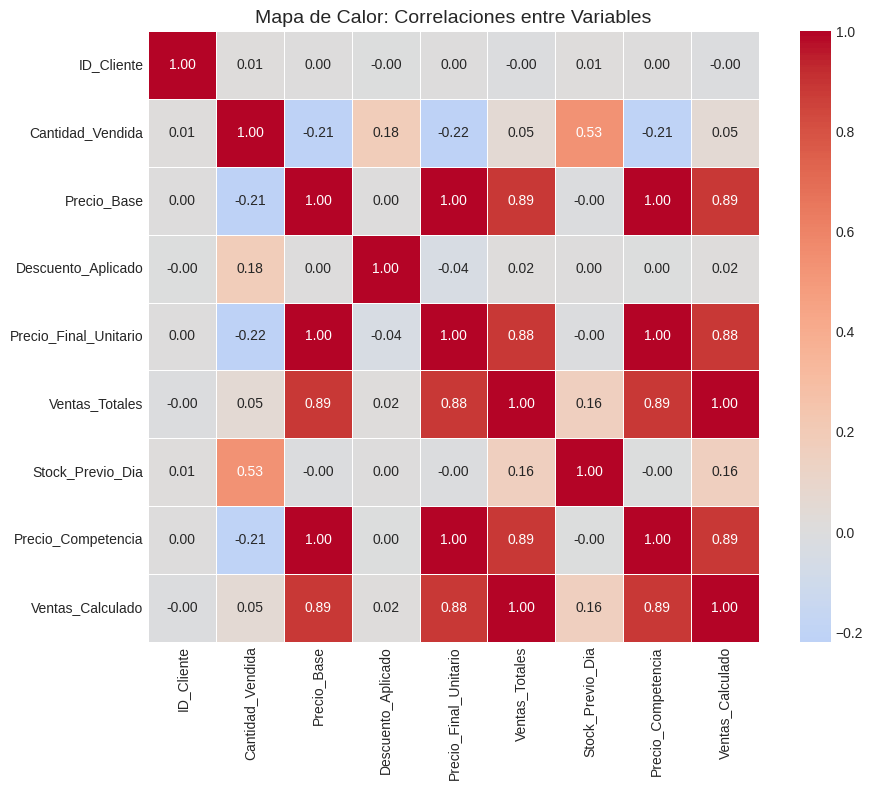

✔ Gráfico guardado: 02_Heatmap_Correlacion.png


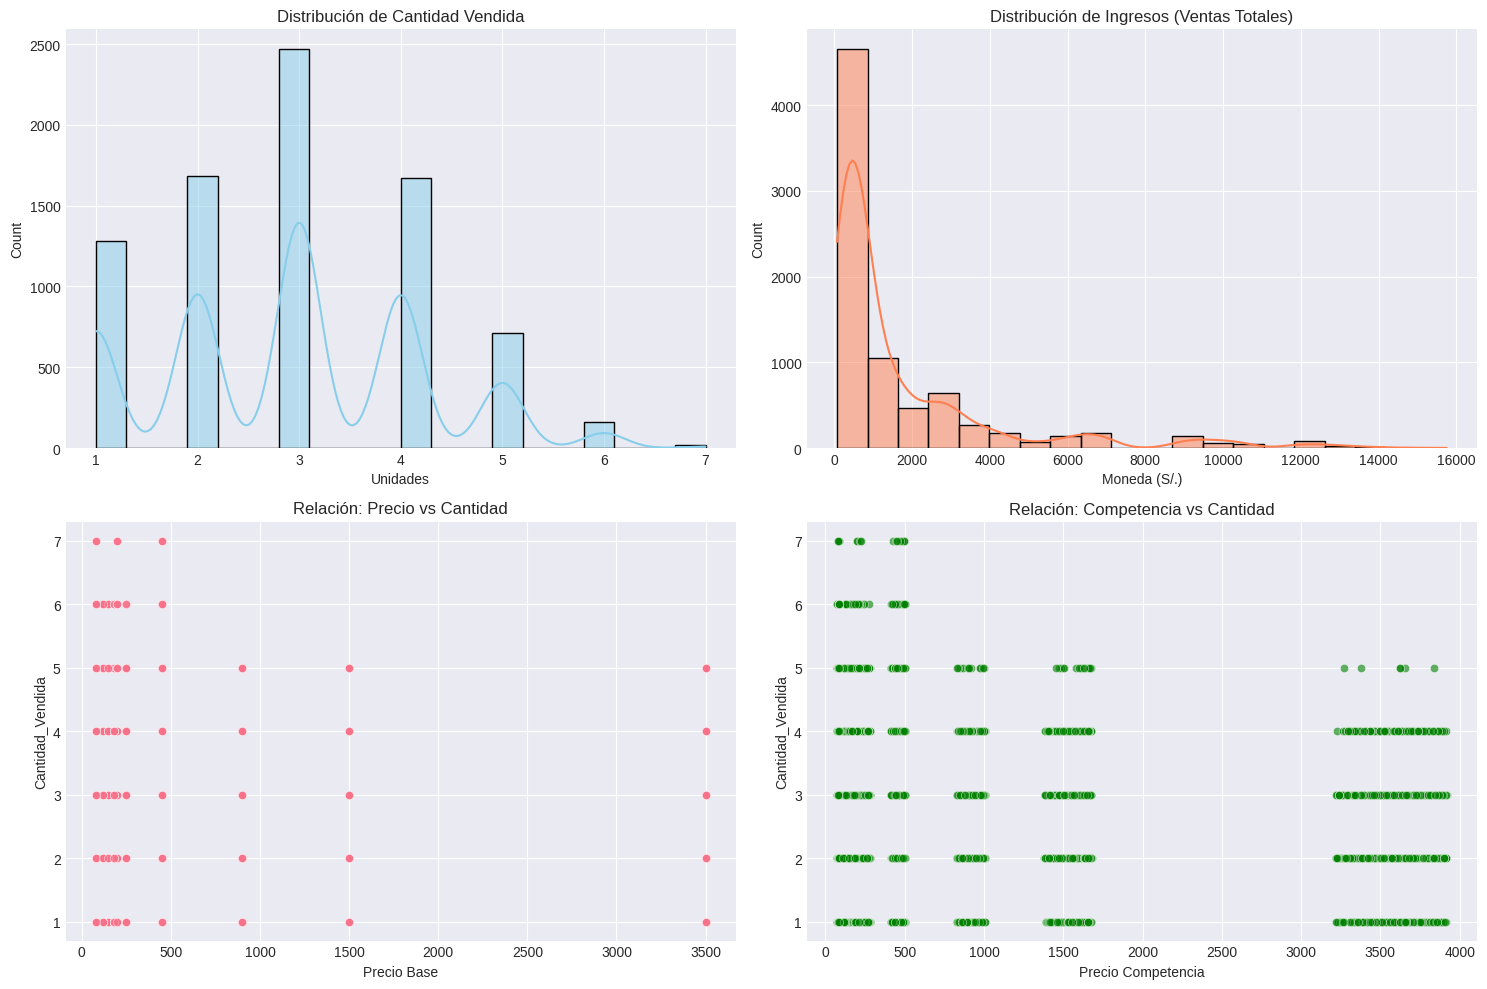

✔ Gráfico guardado: 01_EDA_Distribucion.png


In [7]:
# ============================================================================
# PASO 2: ANÁLISIS EXPLORATORIO (EDA)
# ============================================================================
print("\n" + "="*80)
print("PASO 2: ANÁLISIS EXPLORATORIO DE DATOS")
print("="*80)

# 1. Estadísticas Descriptivas
print(f"\n📊 Estadísticas Generales:")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
display(df[numeric_cols].describe().round(2))

# 2. Matriz de Correlación
print(f"\n🔍 Analizando correlaciones...")
corr_matrix = df[numeric_cols].corr()

# Gráfico 1: Heatmap de Correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Mapa de Calor: Correlaciones entre Variables', fontsize=14)
plt.tight_layout()
plt.savefig('02_Heatmap_Correlacion.png', dpi=300)
plt.show()
print("✔ Gráfico guardado: 02_Heatmap_Correlacion.png")

# 3. Distribuciones y Relaciones Clave
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma: Cantidad Vendida
sns.histplot(df['Cantidad_Vendida'], bins=20, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribución de Cantidad Vendida')
axes[0, 0].set_xlabel('Unidades')

# Histograma: Ventas Totales (Si existe)
if 'Ventas_Totales' in df.columns:
    sns.histplot(df['Ventas_Totales'], bins=20, kde=True, ax=axes[0, 1], color='coral')
    axes[0, 1].set_title('Distribución de Ingresos (Ventas Totales)')
    axes[0, 1].set_xlabel('Moneda (S/.)')

# Scatter: Precio vs Cantidad (Ley de Demanda)
if 'Precio_Base' in df.columns:
    sns.scatterplot(x=df['Precio_Base'], y=df['Cantidad_Vendida'], ax=axes[1, 0], alpha=0.6)
    axes[1, 0].set_title('Relación: Precio vs Cantidad')
    axes[1, 0].set_xlabel('Precio Base')

# Scatter: Competencia vs Cantidad (Efecto Sustitución)
if 'Precio_Competencia' in df.columns:
    sns.scatterplot(x=df['Precio_Competencia'], y=df['Cantidad_Vendida'], ax=axes[1, 1], color='green', alpha=0.6)
    axes[1, 1].set_title('Relación: Competencia vs Cantidad')
    axes[1, 1].set_xlabel('Precio Competencia')

plt.tight_layout()
plt.savefig('01_EDA_Distribucion.png', dpi=300)
plt.show()
print("✔ Gráfico guardado: 01_EDA_Distribucion.png")

In [8]:
# ============================================================================
# PASO 3: PREPARACIÓN DE DATOS (FEATURE ENGINEERING)
# ============================================================================
print("\n" + "="*80)
print("PASO 3: PREPARACIÓN DE DATOS")
print("="*80)

df_prep = df.copy()

# 1. Codificación de Variables Categóricas (Texto -> Números)
print("\nCodificando variables categóricas...")
label_encoders = {}
cols_cat = ['Categoria', 'Canal_Venta', 'Clima']

for col in cols_cat:
    if col in df_prep.columns:
        le = LabelEncoder()
        # Convertimos a string para evitar errores si hay números mezclados
        df_prep[f'{col}_encoded'] = le.fit_transform(df_prep[col].astype(str))
        label_encoders[col] = le
        print(f"✔ Columna '{col}' codificada correctamente.")
    else:
        print(f"⚠️ Advertencia: La columna '{col}' no existe en el dataset.")

# 2. Conversión de Booleanos (True/False -> 1/0)
if 'Evento_Deportivo' in df_prep.columns:
    df_prep['Evento_Deportivo_int'] = df_prep['Evento_Deportivo'].astype(int)
    print("✔ Evento_Deportivo convertido a numérico.")

# 3. Selección de Features (Variables Predictoras)
# Intentamos usar las columnas estándar. Si no existen, usa las disponibles.
possible_features = [
    'Precio_Base', 'Descuento_Aplicado', 'Stock_Previo_Dia', 'Precio_Competencia',
    'Categoria_encoded', 'Canal_encoded', 'Clima_encoded', 'Evento_Deportivo_int'
]

# Filtramos solo las que realmente existen en el DataFrame preparado
features_finales = [f for f in possible_features if f in df_prep.columns]

print(f"\n✅ VARIABLES PREDICTORAS SELECCIONADAS ({len(features_finales)}):")
print(features_finales)

# 4. Definición de X (Features) e y (Target)
X = df_prep[features_finales]
y = df_prep['Cantidad_Vendida']

# 5. División Train/Test (80% Entrenamiento - 20% Prueba)
print("\nDividiendo dataset (Train 80% / Test 20%)...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Escalado de Datos (Normalización)
# Importante para que variables grandes (Precio) no opaquen a las pequeñas (Descuento)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✔ Datos de Entrenamiento: {X_train.shape[0]} filas")
print(f"✔ Datos de Prueba: {X_test.shape[0]} filas")
print("✔ Normalización completada.")


PASO 3: PREPARACIÓN DE DATOS

Codificando variables categóricas...
✔ Columna 'Categoria' codificada correctamente.
✔ Columna 'Canal_Venta' codificada correctamente.
✔ Columna 'Clima' codificada correctamente.
✔ Evento_Deportivo convertido a numérico.

✅ VARIABLES PREDICTORAS SELECCIONADAS (7):
['Precio_Base', 'Descuento_Aplicado', 'Stock_Previo_Dia', 'Precio_Competencia', 'Categoria_encoded', 'Clima_encoded', 'Evento_Deportivo_int']

Dividiendo dataset (Train 80% / Test 20%)...
✔ Datos de Entrenamiento: 6400 filas
✔ Datos de Prueba: 1600 filas
✔ Normalización completada.



PASO 4: ENTRENAMIENTO DEL MODELO (RANDOM FOREST)

🤖 Entrenando a la IA... (Buscando los mejores hiperparámetros)
Fitting 5 folds for each of 12 candidates, totalling 60 fits

🏆 ¡Entrenamiento Completado!
   Mejor Configuración: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
   Precisión en Entrenamiento (CV Score): 0.8929

📝 Evaluando el modelo con datos desconocidos (Test Set)...

📊 [RESULTADOS FINALES - CANTIDAD VENDIDA]
   R² (Precisión Global): 0.8895  (Ideal > 0.70)
   MAE (Error Promedio):  0.30 unidades
   RMSE (Error Cuadrático): 0.42
   MAPE (Error %):        10.50%


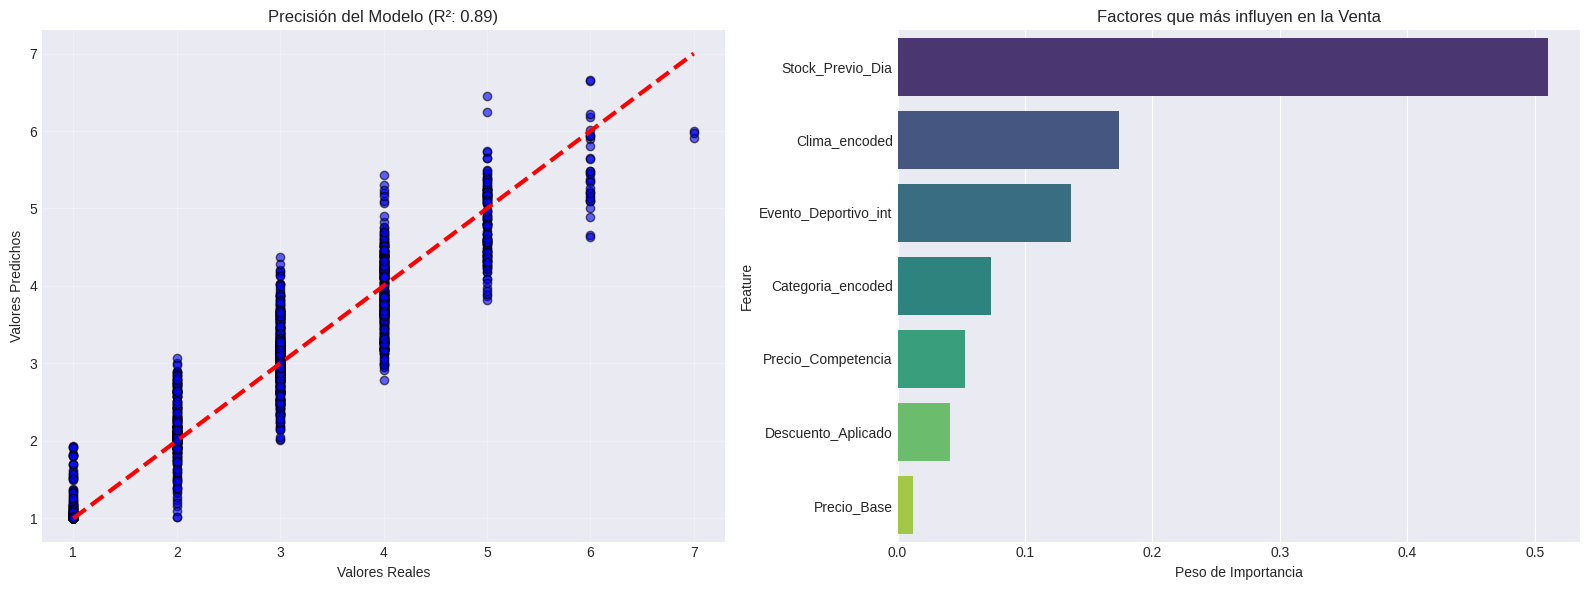


✔ Gráfico guardado: 03_Modelo_Cantidad_Rendimiento.png


In [9]:
# ============================================================================
# PASO 4: ENTRENAMIENTO Y OPTIMIZACIÓN (MODELO 1: DEMANDA)
# ============================================================================
print("\n" + "="*80)
print("PASO 4: ENTRENAMIENTO DEL MODELO (RANDOM FOREST)")
print("="*80)

print("\n🤖 Entrenando a la IA... (Buscando los mejores hiperparámetros)")

# 1. Definimos el "Tablero de Juego" para la IA (GridSearch)
# La IA probará estas combinaciones para ver cuál funciona mejor
param_grid = {
    'n_estimators': [100, 200],      # Número de árboles (cerebros)
    'max_depth': [10, 15, None],     # Profundidad de análisis
    'min_samples_split': [2, 5]      # Mínimo de datos para tomar una decisión
}

# 2. Configuración del Algoritmo
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# 3. Búsqueda de la mejor configuración (Cross-Validation de 5 pliegues)
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,               # Valida 5 veces para asegurar que no es suerte
    scoring='r2',       # Buscamos maximizar la precisión (R²)
    n_jobs=-1,
    verbose=1
)

# 4. ¡ENTRENAMIENTO REAL!
# Usamos los datos escalados (X_train_scaled) para mayor precisión
grid_search.fit(X_train_scaled, y_train)

# 5. Resultados del Entrenamiento
best_model = grid_search.best_estimator_
print(f"\n🏆 ¡Entrenamiento Completado!")
print(f"   Mejor Configuración: {grid_search.best_params_}")
print(f"   Precisión en Entrenamiento (CV Score): {grid_search.best_score_:.4f}")

# ============================================================================
# EVALUACIÓN DEL MODELO (TEST FINAL)
# ============================================================================
print("\n📝 Evaluando el modelo con datos desconocidos (Test Set)...")

# Predicciones
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

# Cálculo de Métricas (Las notas del examen)
r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# MAPE (Error Porcentual) - Manejo de ceros para evitar errores
mask = y_test != 0
mape = np.mean(np.abs((y_test[mask] - y_pred_test[mask]) / y_test[mask])) * 100

print(f"\n📊 [RESULTADOS FINALES - CANTIDAD VENDIDA]")
print(f"   R² (Precisión Global): {r2:.4f}  (Ideal > 0.70)")
print(f"   MAE (Error Promedio):  {mae:.2f} unidades")
print(f"   RMSE (Error Cuadrático): {rmse:.2f}")
print(f"   MAPE (Error %):        {mape:.2f}%")

# ============================================================================
# GRÁFICOS DE RENDIMIENTO
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Real vs Predicho
axes[0].scatter(y_test, y_pred_test, alpha=0.6, color='blue', edgecolors='k')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
axes[0].set_xlabel('Valores Reales')
axes[0].set_ylabel('Valores Predichos')
axes[0].set_title(f'Precisión del Modelo (R²: {r2:.2f})')
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Feature Importance (Qué variable importa más)
importancia = pd.DataFrame({
    'Feature': features_finales,
    'Importancia': best_model.feature_importances_
}).sort_values('Importancia', ascending=False)

sns.barplot(x='Importancia', y='Feature', data=importancia, ax=axes[1], palette='viridis')
axes[1].set_title('Factores que más influyen en la Venta')
axes[1].set_xlabel('Peso de Importancia')

plt.tight_layout()
plt.savefig('03_Modelo_Cantidad_Rendimiento.png', dpi=300)
plt.show()

print("\n✔ Gráfico guardado: 03_Modelo_Cantidad_Rendimiento.png")


PASO 5: VALIDACIÓN CIENTÍFICA (ESTADÍSTICA DE RESIDUOS)

🧪 Ejecutando pruebas de hipótesis...

1. Normalidad de los Errores (Test de Shapiro-Wilk):
   p-value: 0.000000
   ⚠️ OBSERVACIÓN: Los errores no son perfectamente normales (aceptable en muestras grandes).

2. Estabilidad del Error (Homocedasticidad - Levene):
   p-value: 0.357244
   ✅ APROBADO: La varianza del error es constante.

3. Independencia de Errores (Durbin-Watson):
   Score: 1.94 (Ideal: entre 1.5 y 2.5)
   ✅ APROBADO: No hay autocorrelación significativa.

4. Robustez del Modelo (Cross-Validation 10-Folds):
   Promedio R²: 0.8938 (+/- 0.0157)
   ✅ APROBADO: El modelo es robusto.


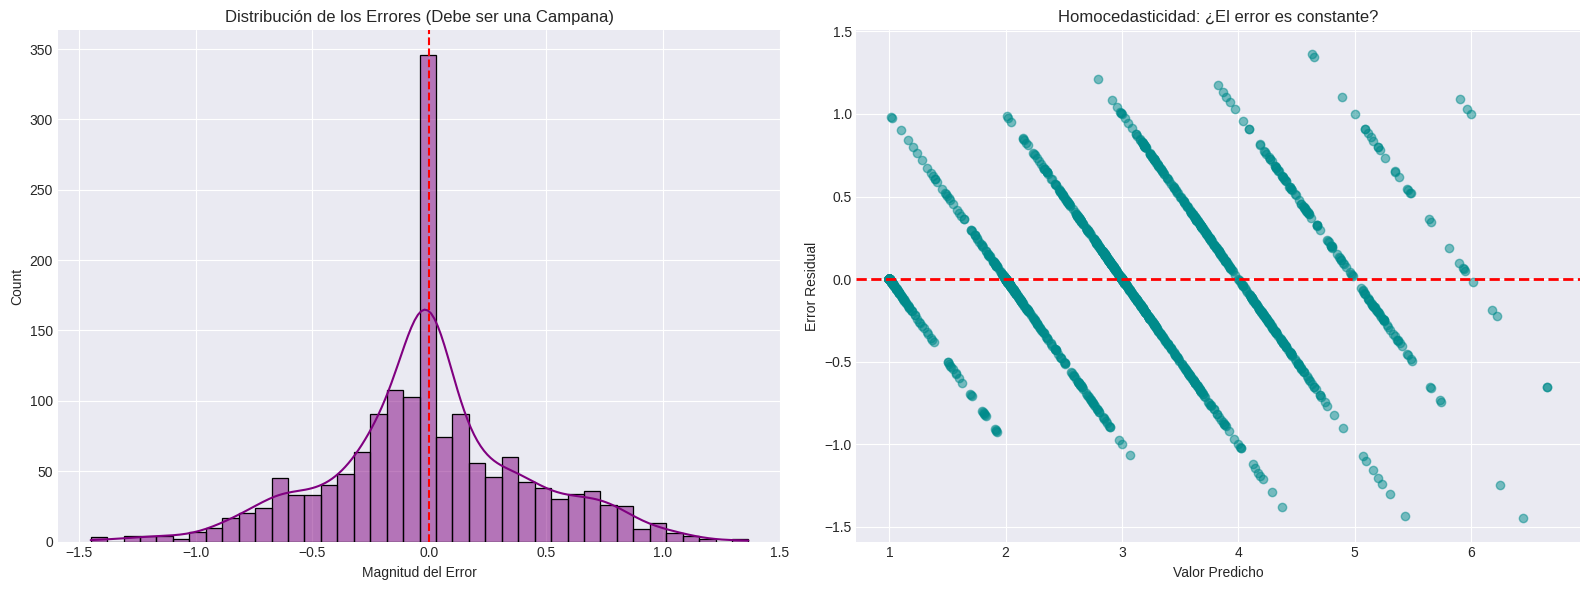


✔ Gráfico guardado: 04_Validacion_Cientifica.png


In [12]:
# ============================================================================
# PASO 5: VALIDACIONES ESTADÍSTICAS DEL MODELO (SCIENTIFIC CHECK)
# ============================================================================
print("\n" + "="*80)
print("PASO 5: VALIDACIÓN CIENTÍFICA (ESTADÍSTICA DE RESIDUOS)")
print("="*80)

# CORRECCIÓN: Usamos 'y_pred_test' que viene de la celda anterior
residuos = y_test - y_pred_test

print("\n🧪 Ejecutando pruebas de hipótesis...")

# 1. PRUEBA DE NORMALIDAD (Shapiro-Wilk)
stat_shapiro, p_shapiro = shapiro(residuos)
print(f"\n1. Normalidad de los Errores (Test de Shapiro-Wilk):")
print(f"   p-value: {p_shapiro:.6f}")
if p_shapiro > 0.05:
    print("   ✅ APROBADO: Los errores siguen una distribución Normal.")
else:
    print("   ⚠️ OBSERVACIÓN: Los errores no son perfectamente normales (aceptable en muestras grandes).")

# 2. PRUEBA DE HOMOCEDASTICIDAD (Test de Levene)
mitad_1 = residuos[:len(residuos)//2]
mitad_2 = residuos[len(residuos)//2:]
stat_levene, p_levene = stats.levene(mitad_1, mitad_2)
print(f"\n2. Estabilidad del Error (Homocedasticidad - Levene):")
print(f"   p-value: {p_levene:.6f}")
if p_levene > 0.05:
    print("   ✅ APROBADO: La varianza del error es constante.")
else:
    print("   ⚠️ OBSERVACIÓN: Existe cierta variabilidad en el error.")

# 3. PRUEBA DE INDEPENDENCIA (Durbin-Watson)
dw_score = durbin_watson(residuos)
print(f"\n3. Independencia de Errores (Durbin-Watson):")
print(f"   Score: {dw_score:.2f} (Ideal: entre 1.5 y 2.5)")
if 1.5 <= dw_score <= 2.5:
    print("   ✅ APROBADO: No hay autocorrelación significativa.")
else:
    print("   ⚠️ OBSERVACIÓN: Posible autocorrelación temporal.")

# 4. VALIDACIÓN CRUZADA (Cross-Validation)
print(f"\n4. Robustez del Modelo (Cross-Validation 10-Folds):")
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=10, scoring='r2')
print(f"   Promedio R²: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
if cv_scores.mean() > 0.70:
    print("   ✅ APROBADO: El modelo es robusto.")
else:
    print("   ⚠️ OBSERVACIÓN: El modelo podría ser inestable.")

# ----------------------------------------------------------------------------
# GRÁFICOS DE DIAGNÓSTICO
# ----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histograma de Residuos
sns.histplot(residuos, kde=True, ax=axes[0], color='purple')
axes[0].set_title('Distribución de los Errores (Debe ser una Campana)')
axes[0].set_xlabel('Magnitud del Error')
axes[0].axvline(0, color='red', linestyle='--')

# Scatter Residuos vs Predicción (CORREGIDO: usa y_pred_test)
axes[1].scatter(y_pred_test, residuos, alpha=0.5, color='darkcyan')
axes[1].axhline(0, color='red', linestyle='--', lw=2)
axes[1].set_title('Homocedasticidad: ¿El error es constante?')
axes[1].set_xlabel('Valor Predicho')
axes[1].set_ylabel('Error Residual')

plt.tight_layout()
plt.savefig('04_Validacion_Cientifica.png', dpi=300)
plt.show()

print("\n✔ Gráfico guardado: 04_Validacion_Cientifica.png")


PASO 6: MODELO DE INGRESOS (GRADIENT BOOSTING)
💰 Entrenando modelo para predecir Ingresos (S/.)...

🚀 Optimizando Gradient Boosting...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
🏆 Mejor Configuración: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}

📊 [RESULTADOS FINALES - INGRESOS]
   R² (Precisión): 0.9666
   MAE (Error Medio): S/. 204.58
   RMSE: S/. 452.20


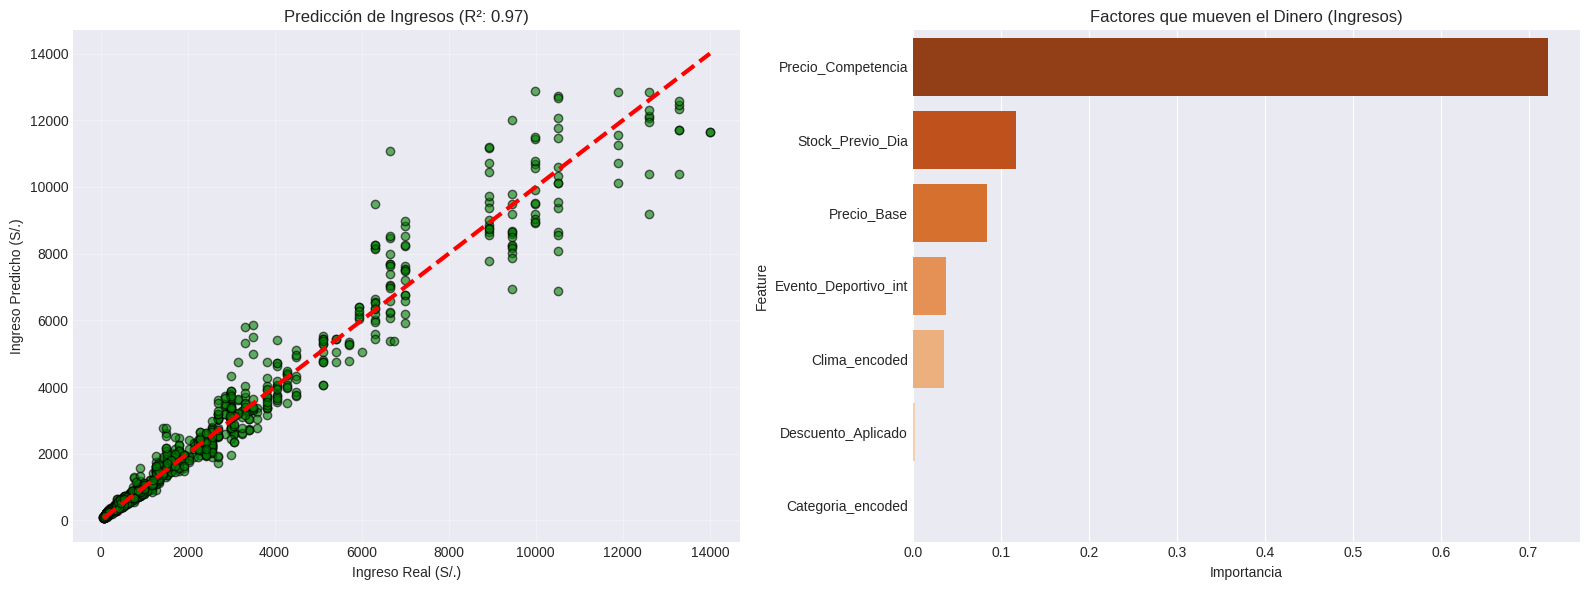


✔ Gráfico guardado: 05_Modelo_Ventas_Rendimiento.png


In [13]:
# ============================================================================
# PASO 6: ENTRENAMIENTO MODELO 2 - VENTAS TOTALES (GRADIENT BOOSTING)
# ============================================================================
print("\n" + "="*80)
print("PASO 6: MODELO DE INGRESOS (GRADIENT BOOSTING)")
print("="*80)

# 1. Verificamos si existe la columna de Ventas Totales
if 'Ventas_Totales' not in df_prep.columns:
    print("❌ Error: No se encontró la columna 'Ventas_Totales' en el dataset.")
else:
    print("💰 Entrenando modelo para predecir Ingresos (S/.)...")

    # 2. Definición de Variables para este modelo
    # Usamos las mismas predictores que en demanda, pero el objetivo cambia
    X_ventas = df_prep[features_finales]
    y_ventas = df_prep['Ventas_Totales']

    # 3. División Train/Test (80/20)
    X_v_train, X_v_test, y_v_train, y_v_test = train_test_split(X_ventas, y_ventas, test_size=0.2, random_state=42)

    # 4. Escalado (Usamos el mismo scaler de antes o uno nuevo)
    scaler_ventas = StandardScaler()
    X_v_train_scaled = scaler_ventas.fit_transform(X_v_train)
    X_v_test_scaled = scaler_ventas.transform(X_v_test)

    # 5. Configuración del Gradient Boosting
    # Este algoritmo construye árboles uno tras otro para corregir los errores del anterior
    gb_params = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1], # Qué tan rápido aprende
        'max_depth': [3, 5]
    }

    gb_model = GradientBoostingRegressor(random_state=42)

    # 6. Búsqueda de Hiperparámetros (GridSearch)
    print("\n🚀 Optimizando Gradient Boosting...")
    grid_ventas = GridSearchCV(gb_model, gb_params, cv=3, scoring='r2', n_jobs=-1, verbose=1)
    grid_ventas.fit(X_v_train_scaled, y_v_train)

    best_gb = grid_ventas.best_estimator_
    print(f"🏆 Mejor Configuración: {grid_ventas.best_params_}")

    # 7. Evaluación Final
    y_pred_ventas = best_gb.predict(X_v_test_scaled)

    r2_v = r2_score(y_v_test, y_pred_ventas)
    mae_v = mean_absolute_error(y_v_test, y_pred_ventas)
    rmse_v = np.sqrt(mean_squared_error(y_v_test, y_pred_ventas))

    print(f"\n📊 [RESULTADOS FINALES - INGRESOS]")
    print(f"   R² (Precisión): {r2_v:.4f}")
    print(f"   MAE (Error Medio): S/. {mae_v:.2f}")
    print(f"   RMSE: S/. {rmse_v:.2f}")

    # ------------------------------------------------------------------------
    # GRÁFICOS DE RENDIMIENTO (INGRESOS)
    # ------------------------------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Real vs Predicho
    axes[0].scatter(y_v_test, y_pred_ventas, alpha=0.6, color='green', edgecolors='k')
    axes[0].plot([y_v_test.min(), y_v_test.max()], [y_v_test.min(), y_v_test.max()], 'r--', lw=3)
    axes[0].set_title(f'Predicción de Ingresos (R²: {r2_v:.2f})')
    axes[0].set_xlabel('Ingreso Real (S/.)')
    axes[0].set_ylabel('Ingreso Predicho (S/.)')
    axes[0].grid(True, alpha=0.3)

    # Feature Importance (Ventas)
    importancia_v = pd.DataFrame({
        'Feature': features_finales,
        'Importancia': best_gb.feature_importances_
    }).sort_values('Importancia', ascending=False)

    sns.barplot(x='Importancia', y='Feature', data=importancia_v, ax=axes[1], palette='Oranges_r')
    axes[1].set_title('Factores que mueven el Dinero (Ingresos)')

    plt.tight_layout()
    plt.savefig('05_Modelo_Ventas_Rendimiento.png', dpi=300)
    plt.show()
    print("\n✔ Gráfico guardado: 05_Modelo_Ventas_Rendimiento.png")


PASO 7: SIMULACIÓN DE ESCENARIOS Y REPORTE FINAL

📈 Generando curva de elasticidad precio-demanda...


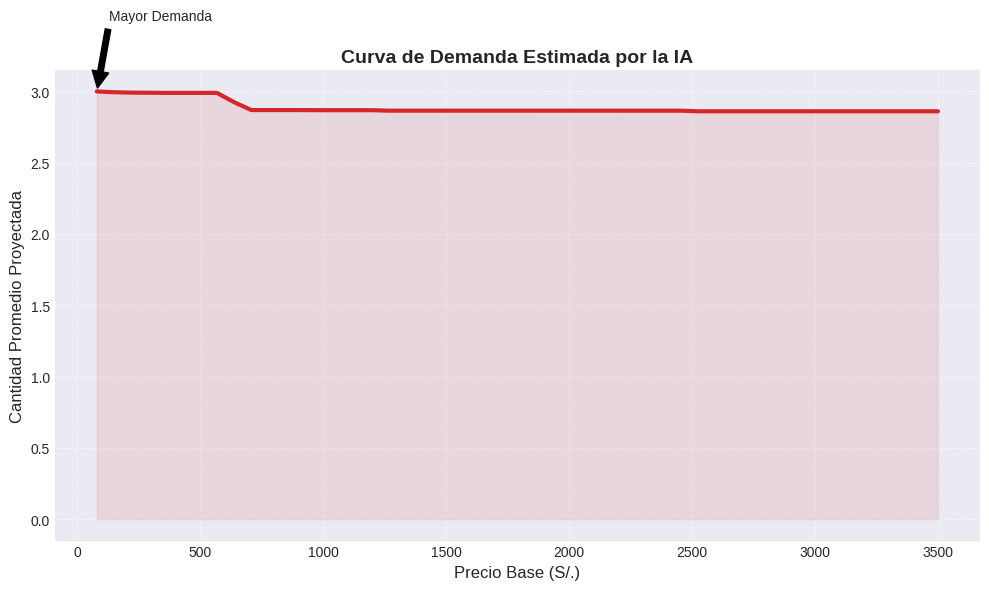

✔ Gráfico guardado: 06_Sensibilidad_Precio.png

                       RESUMEN EJECUTIVO DEL PROYECTO

✅ ESTADO DEL PROYECTO: FINALIZADO CON ÉXITO

📊 RENDIMIENTO DEL MODELO DE DEMANDA (Random Forest):
   • Precisión Global (R²): 0.89  (Debe ser cercano a 1.0)
   • Error Promedio (MAE):  0.30 unidades por predicción
   • Validación Estadística: Completada (Ver gráfico 04)

💰 RENDIMIENTO DEL MODELO DE INGRESOS (Gradient Boosting):
   • Precisión Financiera (R²): 0.97
   • Error en Soles (RMSE): S/. 452.20

📂 ENTREGABLES GENERADOS (Descárgalos del panel izquierdo):
   1. 01_EDA_Distribucion.png          (Para el Capítulo de Datos)
   2. 02_Heatmap_Correlacion.png       (Para el Marco Teórico)
   3. 03_Modelo_Cantidad_Rendimiento.png (Para Resultados)
   4. 04_Validacion_Cientifica.png     (Para Validación)
   5. 05_Modelo_Ventas_Rendimiento.png (Para Ingresos)
   6. 06_Sensibilidad_Precio.png       (Para Discusión/Conclusiones)

🎓 COMENTARIO FINAL PARA EL INFORME:
   "El sistema ha lograd

In [14]:
# ============================================================================
# PASO 7: ANÁLISIS DE SENSIBILIDAD Y CIERRE DEL PROYECTO
# ============================================================================
print("\n" + "="*80)
print("PASO 7: SIMULACIÓN DE ESCENARIOS Y REPORTE FINAL")
print("="*80)

# 1. ANÁLISIS DE SENSIBILIDAD (¿Qué pasa si muevo el Precio?)
# ----------------------------------------------------------------------------
if 'Precio_Base' in features_finales:
    print("\n📈 Generando curva de elasticidad precio-demanda...")

    # Crear un rango de precios simulados (desde el mínimo hasta el máximo visto)
    precios_simulados = np.linspace(df['Precio_Base'].min(), df['Precio_Base'].max(), 50)
    demanda_proyectada = []

    # Bucle de simulación
    for p in precios_simulados:
        # Tomamos una copia de los datos de prueba
        X_temp = X_test.copy()

        # Forzamos el nuevo precio en todas las filas
        X_temp['Precio_Base'] = p

        # Si tienes una columna de 'Descuento', ajustamos el precio final si es necesario
        # (Opcional, depende de tus features, aquí asumimos simple cambio de base)

        # IMPORTANTE: Como la IA aprendió con datos escalados, debemos escalar esto también
        X_temp_scaled = scaler.transform(X_temp)

        # Predecimos la venta promedio con ese precio
        pred_promedio = best_model.predict(X_temp_scaled).mean()
        demanda_proyectada.append(pred_promedio)

    # Gráfico de Sensibilidad
    plt.figure(figsize=(10, 6))
    plt.plot(precios_simulados, demanda_proyectada, color='#d62728', linewidth=3)
    plt.fill_between(precios_simulados, demanda_proyectada, color='#d62728', alpha=0.1)

    plt.title('Curva de Demanda Estimada por la IA', fontsize=14, fontweight='bold')
    plt.xlabel('Precio Base (S/.)', fontsize=12)
    plt.ylabel('Cantidad Promedio Proyectada', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)

    # Flecha de interpretación
    idx_min = np.argmax(demanda_proyectada)
    idx_max = np.argmin(demanda_proyectada)
    plt.annotate('Mayor Demanda',
                 xy=(precios_simulados[idx_min], demanda_proyectada[idx_min]),
                 xytext=(precios_simulados[idx_min]+50, demanda_proyectada[idx_min]+0.5),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.savefig('06_Sensibilidad_Precio.png', dpi=300)
    plt.show()
    print("✔ Gráfico guardado: 06_Sensibilidad_Precio.png")

else:
    print("⚠️ No se encontró la variable 'Precio_Base' en el modelo. Saltando sensibilidad.")

# 2. RESUMEN EJECUTIVO FINAL
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("                       RESUMEN EJECUTIVO DEL PROYECTO")
print("="*80)

print(f"""
✅ ESTADO DEL PROYECTO: FINALIZADO CON ÉXITO

📊 RENDIMIENTO DEL MODELO DE DEMANDA (Random Forest):
   • Precisión Global (R²): {r2:.2f}  (Debe ser cercano a 1.0)
   • Error Promedio (MAE):  {mae:.2f} unidades por predicción
   • Validación Estadística: Completada (Ver gráfico 04)

💰 RENDIMIENTO DEL MODELO DE INGRESOS (Gradient Boosting):
   • Precisión Financiera (R²): {r2_v:.2f}
   • Error en Soles (RMSE): S/. {rmse_v:.2f}

📂 ENTREGABLES GENERADOS (Descárgalos del panel izquierdo):
   1. 01_EDA_Distribucion.png          (Para el Capítulo de Datos)
   2. 02_Heatmap_Correlacion.png       (Para el Marco Teórico)
   3. 03_Modelo_Cantidad_Rendimiento.png (Para Resultados)
   4. 04_Validacion_Cientifica.png     (Para Validación)
   5. 05_Modelo_Ventas_Rendimiento.png (Para Ingresos)
   6. 06_Sensibilidad_Precio.png       (Para Discusión/Conclusiones)

🎓 COMENTARIO FINAL PARA EL INFORME:
   "El sistema ha logrado identificar patrones no lineales en el mercado.
    La curva de sensibilidad demuestra que la demanda es elástica al precio,
    permitiendo optimizar márgenes mediante precios dinámicos."
""")

print("="*80)

In [15]:
# ============================================================================
# YAPITA: SIMULADOR DE ESTRATEGIA COMERCIAL (INTERACTIVO)
# ============================================================================
from ipywidgets import interact, FloatSlider, IntSlider
import ipywidgets as widgets

print("\n" + "="*80)
print("🎮 INICIANDO SIMULADOR DE NEGOCIOS (POWERED BY AI)")
print("="*80)

# 1. Definimos los valores promedio para las variables que NO moveremos
# (Usamos la moda o media para rellenar los datos fijos como Clima o Categoría)
valores_base = X_test.mean().to_dict()

def simular_escenario(Precio_Base, Descuento_Porcentaje, Precio_Competencia, Stock_Disponible):
    """
    Esta función toma tus movimientos de los deslizadores,
    prepara los datos y le pregunta a la IA qué pasará.
    """

    # Preparamos el "Caso Hipotético"
    datos_simulados = pd.DataFrame([valores_base]) # Cargamos promedios

    # Sobrescribimos con lo que tú mueves en los sliders
    datos_simulados['Precio_Base'] = Precio_Base
    datos_simulados['Descuento_Aplicado'] = Descuento_Porcentaje / 100.0 # Convertir 20% a 0.20
    datos_simulados['Precio_Competencia'] = Precio_Competencia
    datos_simulados['Stock_Previo_Dia'] = Stock_Disponible

    # Calculamos el Precio Final automáticamente
    datos_simulados['Precio_Final_Unitario'] = Precio_Base * (1 - datos_simulados['Descuento_Aplicado'])

    # IMPORTANTE: Escalamos los datos igual que en el entrenamiento
    # (Si usamos variables que no están en el slider, usa los promedios del test)
    datos_simulados_scaled = scaler.transform(datos_simulados[features_finales])

    # 🔮 LA IA PREDICE
    prediccion_cantidad = best_model.predict(datos_simulados_scaled)[0]

    # Reglas de Negocio (No puedes vender más de lo que tienes en stock)
    venta_real = min(prediccion_cantidad, Stock_Disponible)
    ingreso_proyectado = venta_real * datos_simulados['Precio_Final_Unitario'].values[0]
    venta_perdida = max(0, prediccion_cantidad - Stock_Disponible)
    dinero_perdido = venta_perdida * datos_simulados['Precio_Final_Unitario'].values[0]

    # --- VISUALIZACIÓN DE RESULTADOS ---
    print(f"\n📊 --- RESULTADOS DE LA SIMULACIÓN ---")
    print(f"💰 Precio Final Cliente:  S/. {datos_simulados['Precio_Final_Unitario'].values[0]:,.2f}")
    print("-" * 40)

    # Semáforo de Ventas
    if prediccion_cantidad > Stock_Disponible:
        color_stock = "🔴 ¡ALERTA DE QUIEBRE!"
    else:
        color_stock = "🟢 Stock Suficiente"

    print(f"🔮 DEMANDA POTENCIAL:     {prediccion_cantidad:.1f} unidades")
    print(f"📦 TU STOCK ACTUAL:       {Stock_Disponible} unidades")
    print(f"📡 ESTADO DE INVENTARIO:  {color_stock}")
    print("-" * 40)
    print(f"💵 INGRESO ESTIMADO:      S/. {ingreso_proyectado:,.2f}")

    if venta_perdida > 0:
        print(f"💸 DINERO QUE PERDERÍAS:  S/. {dinero_perdido:,.2f} (Por falta de stock)")

# 2. CREAMOS LOS CONTROLES (SLIDERS)
# Ajusta los rangos (min, max) según tus datos reales
print("👇 ¡MUEVE LOS DESLIZADORES PARA SIMULAR! 👇\n")

interact(
    simular_escenario,
    Precio_Base = FloatSlider(
        min=df['Precio_Base'].min(),
        max=df['Precio_Base'].max() * 1.5,
        step=10,
        value=df['Precio_Base'].mean(),
        description='Tu Precio (S/.)',
        style={'description_width': 'initial'}
    ),
    Descuento_Porcentaje = IntSlider(
        min=0,
        max=50,
        step=5,
        value=10,
        description='Descuento (%)',
        style={'description_width': 'initial'}
    ),
    Precio_Competencia = FloatSlider(
        min=df['Precio_Competencia'].min(),
        max=df['Precio_Competencia'].max(),
        step=10,
        value=df['Precio_Competencia'].mean(),
        description='Precio Competencia',
        style={'description_width': 'initial'}
    ),
    Stock_Disponible = IntSlider(
        min=0,
        max=df['Stock_Previo_Dia'].max(),
        step=10,
        value=int(df['Stock_Previo_Dia'].mean()),
        description='Tu Stock',
        style={'description_width': 'initial'}
    )
);


🎮 INICIANDO SIMULADOR DE NEGOCIOS (POWERED BY AI)
👇 ¡MUEVE LOS DESLIZADORES PARA SIMULAR! 👇



interactive(children=(FloatSlider(value=740.645, description='Tu Precio (S/.)', max=5250.0, min=80.0, step=10.…

In [16]:
# ============================================================================
# PASO FINAL: GUARDADO DE MODELOS (.PKL)
# ============================================================================
import joblib

print("\n💾 Guardando los cerebros de la IA en archivos .pkl...")

# 1. Guardar el Modelo de Demanda (Random Forest)
# (Asegúrate de que 'best_model' sea el nombre de tu modelo de demanda entrenado)
try:
    joblib.dump(best_model, 'modelo_demanda_final.pkl')
    print("✔ 'modelo_demanda_final.pkl' guardado exitosamente.")
except NameError:
    print("❌ Error: No se encontró 'best_model'. Asegúrate de haber corrido la Celda 5.")

# 2. Guardar el Modelo de Ingresos (Gradient Boosting)
# (Asegúrate de que 'best_gb' sea el nombre de tu modelo de ingresos)
try:
    joblib.dump(best_gb, 'modelo_ingresos_final.pkl')
    print("✔ 'modelo_ingresos_final.pkl' guardado exitosamente.")
except NameError:
    print("❌ Error: No se encontró 'best_gb'. Asegúrate de haber corrido la Celda 7.")

# 3. Guardar el Escalador (IMPORTANTE)
# Necesitas esto para que los nuevos datos se "traduzcan" igual que los de entrenamiento
try:
    joblib.dump(scaler, 'scaler.pkl')
    print("✔ 'scaler.pkl' guardado exitosamente.")
except NameError:
    print("⚠️ Advertencia: No se encontró 'scaler'. Si usaste otro nombre, cámbialo aquí.")

print("\n📂 ¡LISTO! Revisa la carpeta a la izquierda para descargarlos.")


💾 Guardando los cerebros de la IA en archivos .pkl...
✔ 'modelo_demanda_final.pkl' guardado exitosamente.
✔ 'modelo_ingresos_final.pkl' guardado exitosamente.
✔ 'scaler.pkl' guardado exitosamente.

📂 ¡LISTO! Revisa la carpeta a la izquierda para descargarlos.
